In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

Using MPI version 4.0, 1 processes


In [2]:
n = 3          # index of square grating
a = 1.2            # period 
d = 0.5*a            # side of square
t = 0.3          # thickness of grating
dpml = 1         # PML thickness
pad = 2          # padding between grating and PML

pol = mp.Ez

In [3]:
from meep.materials import Ag

block = mp.Block(mp.Vector3(d,t), center=mp.Vector3(0,0), material=mp.Medium(index=n))

In [4]:
fcen = 1
df = 0.3
nfreqs = 50

src = mp.Source(mp.GaussianSource(fcen, fwidth=df), component=pol, center=mp.Vector3(y=-t/2-pad+0.1), size=mp.Vector3(a))

In [5]:
cell = mp.Vector3(a, 2*(t/2+pad+dpml), a)

sim = mp.Simulation(cell_size=cell,
                    # geometry=[gel, block],
                    default_material=mp.Medium(index=1),
                    geometry=[block],
                    sources=[src],
                    resolution=50,
                    boundary_layers=[mp.PML(dpml,direction = mp.Y)],#[mp.PML(dpml, direction=mp.Y)],
                    k_point=mp.Vector3()
                    )

refl = sim.add_mode_monitor(fcen, df, nfreqs, mp.FluxRegion(center=mp.Vector3(y=-t/2-pad+0.2), size=mp.Vector3(a,0,a)))
tran = sim.add_mode_monitor(fcen, df, nfreqs, mp.FluxRegion(center=mp.Vector3(y=t/2+pad-0.1), size=mp.Vector3(a,0,a)))

     block, center = (0,0,0)
          size (0.6,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9,9,9)


/home/gridsan/mcomella/.conda/envs/pmp/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gridsan/mcomella/.conda/envs/pmp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


<AxesSubplot:xlabel='X', ylabel='Y'>

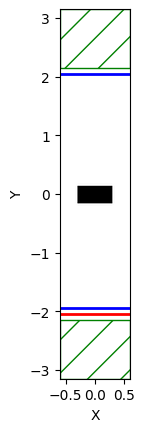

In [6]:
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(a, 2*(t/2+pad+dpml))))

In [7]:
pt = mp.Vector3(y=t/2+pad) # Point to check field
sim.run(mp.to_appended("ez", mp.at_every(100, mp.output_efield_z)),
        until_after_sources=mp.stop_when_fields_decayed(100, pol, pt, 1e-6))

-----------
Initializing structure...
time for choose_chunkdivision = 9.39369e-05 s
Working in 3D dimensions.
Computational cell is 1.2 x 6.3 x 1.2 with resolution 50
     block, center = (0,0,0)
          size (0.6,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9,9,9)
time for set_epsilon = 1.99152 s
-----------
creating output file "./ez.h5"...


: 

: 

In [ ]:
import h5py
f = h5py.File('ez.h5', 'r')
efield_z = np.array(f.get('ez')) # a float tensor of shape (600, 600, 350)
f.close()

In [ ]:
p1_coeff = sim.get_eigenmode_coefficients(refl, [1]).alpha[0]
p2_coeff = sim.get_eigenmode_coefficients(tran, [1]).alpha[0]

c1 = np.array([coef[1] for coef in p1_coeff])
c2 = np.array([coef[0] for coef in p2_coeff])
c3 = np.array([coef[0] for coef in p1_coeff])

In [ ]:
freqs = np.linspace(fcen-df, fcen+df, nfreqs)
wl = 1/freqs
R = np.abs(c1)**2 / np.abs(c3)**2
T = np.abs(c2)**2 / np.abs(c3)**2
plt.plot(wl, R, label='R')
plt.plot(wl, T, label='T')
plt.title('Square grating of index {}, period {}, size {}, resolution {}, polarization {}'.format(n, a, d, sim.resolution, pol))
plt.legend()
title = 'square_grating_{}_{}_{}_{}_{}.png'.format(n, a, d, sim.resolution, pol)
plt.savefig('results/'+title+'.png')

In [ ]:
sim.plot2D(fields=pol, output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(a, 2*(t/2+pad+dpml))))